# DCGAN Ensemble Model 3 (cGANs) training

In this notebook we will continue training the third GAN ensembles following [Ensembles of Generative Adversarial Networks](https://arxiv.org/pdf/1612.00991.pdf) paper.

__Ensemble Model 3 (EM3): Cascade of GANs (cGANs)__.

![](assets/cgan1.png)

> Observation 2: A drawback of GANs as pointed out by Theis et al. is that they potentially do not describe the whole data distribution...

> The cGANs is designed to address the problem described in observation 2; part of the data distribution might be ignored by the GAN. The cGANs framework as illustrated in Figure 2 is designed to train GANs to effectively push the generator to capture the whole distribution of the data instead of focusing on the main mode of the density distribution. It consists of multiple GANs and gates. Each of the GAN trains a generator to capture the current input data distribution which was badly modeled by previous GANs.

> To select the data which is re-directed to the next GAN we use the fact that for badly modeled data x, the discriminator value D(x) is expected to be high. When D(x) is high this means that the discriminator is confident this is real data, which most probably is caused by the fact that there are few generated examples G(z) nearby.

> The results show that the best results are obtained when diverting images to the second GAN with a ratio of 0.7 or 0.8. In the rest of the experiments we fix r = 0.8.

In short, we will:

* In training phase: we start training the first GAN using the complete dataset, then we need to apply the discriminator on all images of the training set, and depending on its prediction value, we will use the gated function Q definition to select the images that have the highest prediction value, present in the target ratio group, to be used as training set of the next GAN. In our case we will use the ratio 0.8 mentioned in the paper, so we just need to apply discriminator on all images, sort it in descending order, and then get the those from the first 80%. We will repeat this process using the original dataset and generating one model each time, until we get 8 models like in the other two ensembles.

* In generation phase: we do the same as eGANs, we choose one of the models randomly each time we need to generate a sample image.

In [1]:
import os
import time
import glob
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl
import numpy as np
from PIL import Image, ImageOps
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from mpl_toolkits.axes_grid1 import ImageGrid

# EM3/cGANs helpers
from commons.utils import is_train_on_gpu, view_samples
from commons import gan_models
from commons.data_helpers import scale
from em3 import data_helpers, train_helpers

In [2]:
dataset_path = 'data/alzheimers_mri_dataset/train'
models_folder = 'em3/models'
# using an odd batch size, if we use 64 the last batch will have only 1 img and will error out,
# instead if we use 63, the last batch will have 41 images which is ok
batch_size = 63
img_size = 128

demented_dataset, demented_train_loader = data_helpers.get_dataset_dataloader(batch_size, img_size, dataset_path)
print(f'dataset size: {len(demented_dataset)}')

dataset size: 2561


In [3]:
# clean models folder
!rm -rf em3/models
!mkdir -p em3/models

In [4]:
# Hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 200

# default hyperparams values according to DCGAN paper
# learning_rate = 0.0002
# beta1 = 0.5
# beta2 = 0.999
# but adding a small variation in learning rate,
#   changing it made the generator and discriminator losses stabilised a bit more quickly
learning_rate = 0.0001
beta1 = 0.5
beta2 = 0.999

n_epochs = 35
print_every = 100

In [5]:
### Note: helper functions defined for the process of
# selecting subset datasets in each cGAN training cycle,
# using gate-function Q to re-direct the data to the next GAN.

def get_predictions_for_dataloader(_Discriminator, dataloader):
    predictions_dict = {}
    for batch_i, (real_images, _, img_paths) in enumerate(dataloader):
        # we need to scale it first because D uses tanh
        real_images = scale(real_images)
        if is_train_on_gpu:
            real_images = real_images.cuda()
        # print('real_images.shape', real_images.shape)
        # view_samples(real_images, f'real batch {batch_i}')

        batch_y = _Discriminator(real_images)
        # print('batch_y', batch_y.shape, batch_y.squeeze().shape, batch_y)
        # d_real_loss = gan_models.real_loss(batch_y)
        # print('real loss after training for this batch:', d_real_loss)

        for idx, img_logits in enumerate(batch_y.squeeze()):
            path = img_paths[idx]
            img_y = torch.sigmoid(img_logits)
            # print('img_y', img_y.item(), path)
            predictions_dict[path] = img_y.item()
            
            # clean gpu mem
            del img_y
            del img_logits
            torch.cuda.empty_cache()
        
        # clean gpu mem
        del batch_y
        del real_images
        torch.cuda.empty_cache()
    
    # sort dict by predictions DESC
    predictions_dict = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1], reverse=True)}
    return predictions_dict


def filter_cgan_gated_subset(discriminator_predictions_dict, cgan_ratio=0.8):
    # return target cgan ratio number of images for the next gan training
    total_imgs_sample = len(discriminator_predictions_dict)
    total_sample_next_cycle = cgan_ratio * total_imgs_sample
    # print(total_imgs_sample, total_sample_next_cycle)
    
    gated_subset_items_dict = {}
    for path, disc_y in discriminator_predictions_dict.items():
        if len(gated_subset_items_dict) >= total_sample_next_cycle:
            break
        gated_subset_items_dict[path] = disc_y
    return gated_subset_items_dict


def get_indexes_by_path_from_dataloader(dataloader, target_items_dict):
    gated_subset_indexes = []
    imgs_idx = 0
    for (real_images, labels, img_paths) in dataloader:
        for idx, img in enumerate(real_images):
            path = img_paths[idx]
            if gated_subset_items_dict.get(path):
                # print(path, imgs_idx)
                gated_subset_indexes.append(imgs_idx)
            imgs_idx = imgs_idx + 1
    return gated_subset_indexes

Something to notice is that now the dataloader holds the path to each image too (img_paths), this is because we need a way to uniquely identify each image object while generating multiple different dataloaders as a dataset of the main one.

In [6]:
# EM3 / cGANs hyperparam
# set number of models to train,
# and the gated function Q ratio for selecting subsets in each cycle 
number_of_models_to_train = 8
cgan_gatefunc_ratio = 0.8

In [7]:
# init dataset and dataloader for the first cycle
target_train_loader = demented_train_loader

start_time = time.time()
losses_list = []
for model_num in range(1, number_of_models_to_train+1):
    print(f' >>> training models started')

    # create discriminator and generator instances
    D, G = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)

    # Create optimizers for the discriminator D and generator G
    d_optimizer = optim.Adam(D.parameters(), learning_rate, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), learning_rate, [beta1, beta2])

    losses = train_helpers.train(target_train_loader, D, G, d_optimizer, g_optimizer, z_size, n_epochs=n_epochs, print_every=print_every)
    losses_list.append(losses)
    
    # save trained generator
    model_path = f'{models_folder}/cgan{model_num}'
    print(f' *** saving model {model_num}: {model_path}')
    torch.save(G.state_dict(), model_path)
    print(f' >>> training model {model_num} finished')
    
    if model_num == number_of_models_to_train:
        # avoid gate function if last model was created
        break
    
    # apply gate-function Q to re-direct the data to the next GAN, create a new subset dataset:
    # in the form of a new dataloader as a subset of the previous one
    # 1) calulation predictions of all images in current dataset using discriminator D
    discriminator_ys_dict = get_predictions_for_dataloader(D, demented_train_loader)
    print(f'current dataset: {len(target_train_loader.dataset)}, global dataset: {len(demented_train_loader.dataset)}')
    disc_values = discriminator_ys_dict.values()
    print(f'discriminator predictions dict: {len(discriminator_ys_dict)}, (min: {min(disc_values)}, max: {max(disc_values)})')
    # 2) filter those images with a high values output from D, along with its unique path str
    gated_subset_items_dict = filter_cgan_gated_subset(discriminator_ys_dict, cgan_gatefunc_ratio)
    gated_subset_values = gated_subset_items_dict.values()
    print(f'gated subset selected: {len(gated_subset_items_dict)}, (min: {min(gated_subset_values)}, max: {max(gated_subset_values)})')
    # 3) get the corresponding index/position of filtered/selected images in current dataset
    gated_subset_indexes_list = get_indexes_by_path_from_dataloader(demented_train_loader, gated_subset_items_dict)
    print('gated subset indexes:', len(gated_subset_indexes_list))
    # 4) create a new subset dataset and dataloader for the next cycle
    target_dataset = torch.utils.data.Subset(demented_train_loader.dataset, gated_subset_indexes_list)
    target_train_loader = torch.utils.data.DataLoader(target_dataset, batch_size=batch_size, shuffle=False)
    print('new target dataset and dataloader created:', len(target_train_loader.dataset))
    
    print(f' >>> training model and gate function applied')


elapsed_time = time.time() - start_time
elapsed_time_hrs = elapsed_time / 60
print(' *** cGANs models trained successfully %ssec %smin' % (elapsed_time, elapsed_time_hrs))

 >>> training models started
 >>> training started
     dataset: 2561
Epoch [    1/   35] | d_loss: 1.1638 | g_loss: 8.0331
Epoch [    2/   35] | d_loss: 0.0033 | g_loss: 16.3991
Epoch [    3/   35] | d_loss: 1.9891 | g_loss: 28.1271
Epoch [    4/   35] | d_loss: 0.3130 | g_loss: 23.6283
Epoch [    5/   35] | d_loss: 3.2168 | g_loss: 45.2351
Epoch [    6/   35] | d_loss: 0.0103 | g_loss: 8.5688
Epoch [    7/   35] | d_loss: 0.2667 | g_loss: 10.8111
Epoch [    8/   35] | d_loss: 1.1473 | g_loss: 20.1664
Epoch [    9/   35] | d_loss: 0.9280 | g_loss: 19.2468
Epoch [   10/   35] | d_loss: 4.0942 | g_loss: 35.8695
Epoch [   11/   35] | d_loss: 0.5956 | g_loss: 18.8128
Epoch [   12/   35] | d_loss: 0.0085 | g_loss: 11.0504
Epoch [   13/   35] | d_loss: 0.4875 | g_loss: 8.5073
Epoch [   14/   35] | d_loss: 2.8220 | g_loss: 15.3068
Epoch [   15/   35] | d_loss: 0.3542 | g_loss: 11.9073
Epoch [   16/   35] | d_loss: 0.9462 | g_loss: 17.8574
Epoch [   17/   35] | d_loss: 0.2643 | g_loss: 3.3817

Epoch [   16/   35] | d_loss: 0.6697 | g_loss: 7.3226
Epoch [   17/   35] | d_loss: 0.3285 | g_loss: 8.8646
Epoch [   18/   35] | d_loss: 0.2728 | g_loss: 4.9925
Epoch [   19/   35] | d_loss: 0.2979 | g_loss: 7.4602
Epoch [   20/   35] | d_loss: 0.1152 | g_loss: 10.1402
Epoch [   21/   35] | d_loss: 0.2487 | g_loss: 6.0693
Epoch [   22/   35] | d_loss: 0.3736 | g_loss: 8.9724
Epoch [   23/   35] | d_loss: 0.8315 | g_loss: 10.9198
Epoch [   24/   35] | d_loss: 0.4480 | g_loss: 4.8853
Epoch [   25/   35] | d_loss: 0.2586 | g_loss: 5.5004
Epoch [   26/   35] | d_loss: 0.2006 | g_loss: 5.3538
Epoch [   27/   35] | d_loss: 0.3271 | g_loss: 7.1761
Epoch [   28/   35] | d_loss: 0.7356 | g_loss: 1.9194
Epoch [   29/   35] | d_loss: 1.0141 | g_loss: 0.2798
Epoch [   30/   35] | d_loss: 0.5912 | g_loss: 1.0616
Epoch [   31/   35] | d_loss: 0.5178 | g_loss: 1.0619
Epoch [   32/   35] | d_loss: 0.9370 | g_loss: 0.3905
Epoch [   33/   35] | d_loss: 0.4176 | g_loss: 1.0646
Epoch [   34/   35] | d_lo

Epoch [   32/   35] | d_loss: 0.3101 | g_loss: 3.9937
Epoch [   33/   35] | d_loss: 0.2432 | g_loss: 2.5656
Epoch [   34/   35] | d_loss: 0.8838 | g_loss: 1.5018
Epoch [   35/   35] | d_loss: 0.4755 | g_loss: 7.4590
 >>> training finished 604.3976137638092sec 10.073293562730154min
 *** saving model 7: em3/models/cgan7
 >>> training model 7 finished
current dataset: 2049, global dataset: 2561
discriminator predictions dict: 2561, (min: 5.401021189754829e-05, max: 0.9999998807907104)
gated subset selected: 2049, (min: 0.8711364269256592, max: 0.9999998807907104)
gated subset indexes: 2049
new target dataset and dataloader created: 2049
 >>> training model and gate function applied
 >>> training models started
 >>> training started
     dataset: 2049
Epoch [    1/   35] | d_loss: 3.9629 | g_loss: 6.5441
Epoch [    2/   35] | d_loss: 0.0506 | g_loss: 14.4052
Epoch [    3/   35] | d_loss: 0.0444 | g_loss: 19.1214
Epoch [    4/   35] | d_loss: 0.0422 | g_loss: 25.7187
Epoch [    5/   35] | d

In the last part of each trining cycle, we can see how we are selecting a new training set for the next GAN. We calculate the predictions of all images, filter those with high value, get the indexes of the selected group, and then create the next subset.

Now lets see the losses of all cGANs trained.

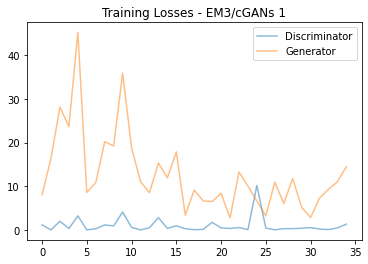

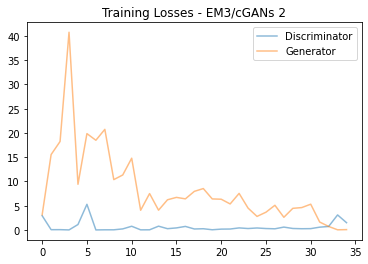

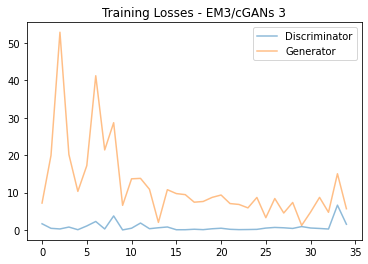

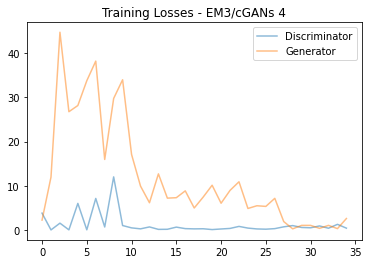

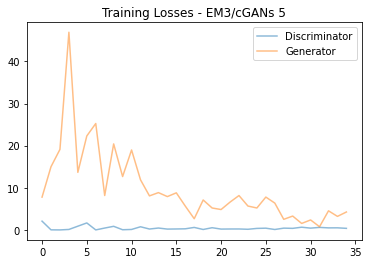

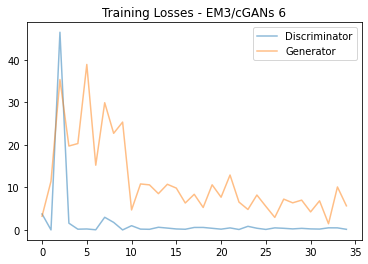

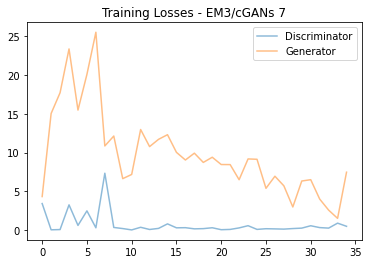

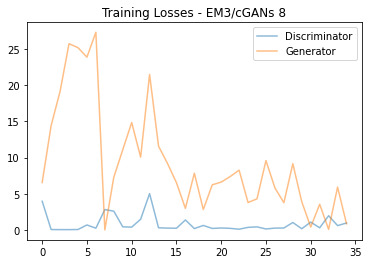

In [8]:
for model_num, losses in enumerate(losses_list):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title(f"Training Losses - EM3/cGANs {model_num+1}")
    plt.legend()

We can observe the same behavior than the other ensembles, losses are low around epoch 30 and keep oscilating, and no model have the same behavior in general, different discriminator and generator losses.

 *** instantiating model: em3/models/cgan1
 *** instantiating model: em3/models/cgan2
 *** instantiating model: em3/models/cgan3
 *** instantiating model: em3/models/cgan4
 *** instantiating model: em3/models/cgan5
 *** instantiating model: em3/models/cgan6
 *** instantiating model: em3/models/cgan7
 *** instantiating model: em3/models/cgan8


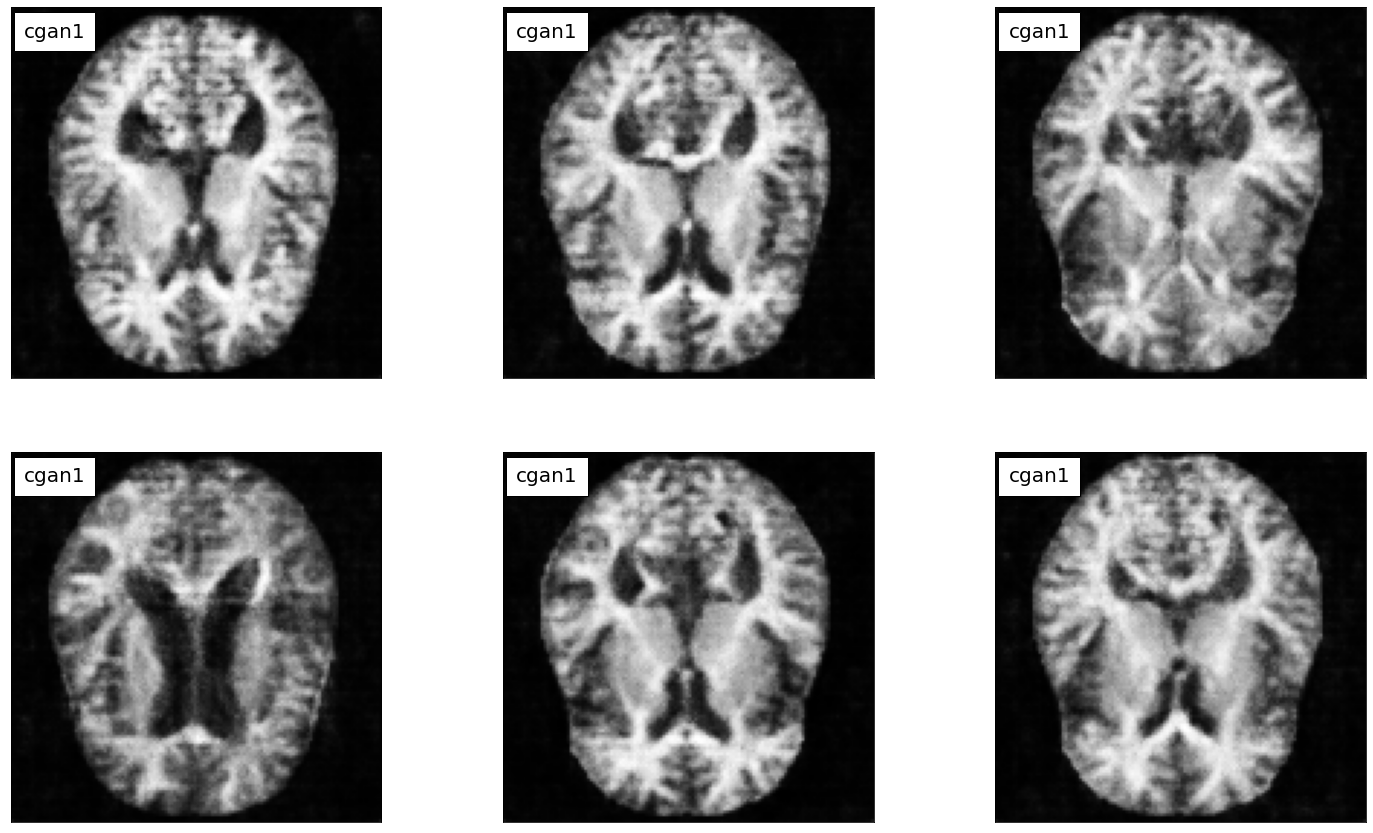

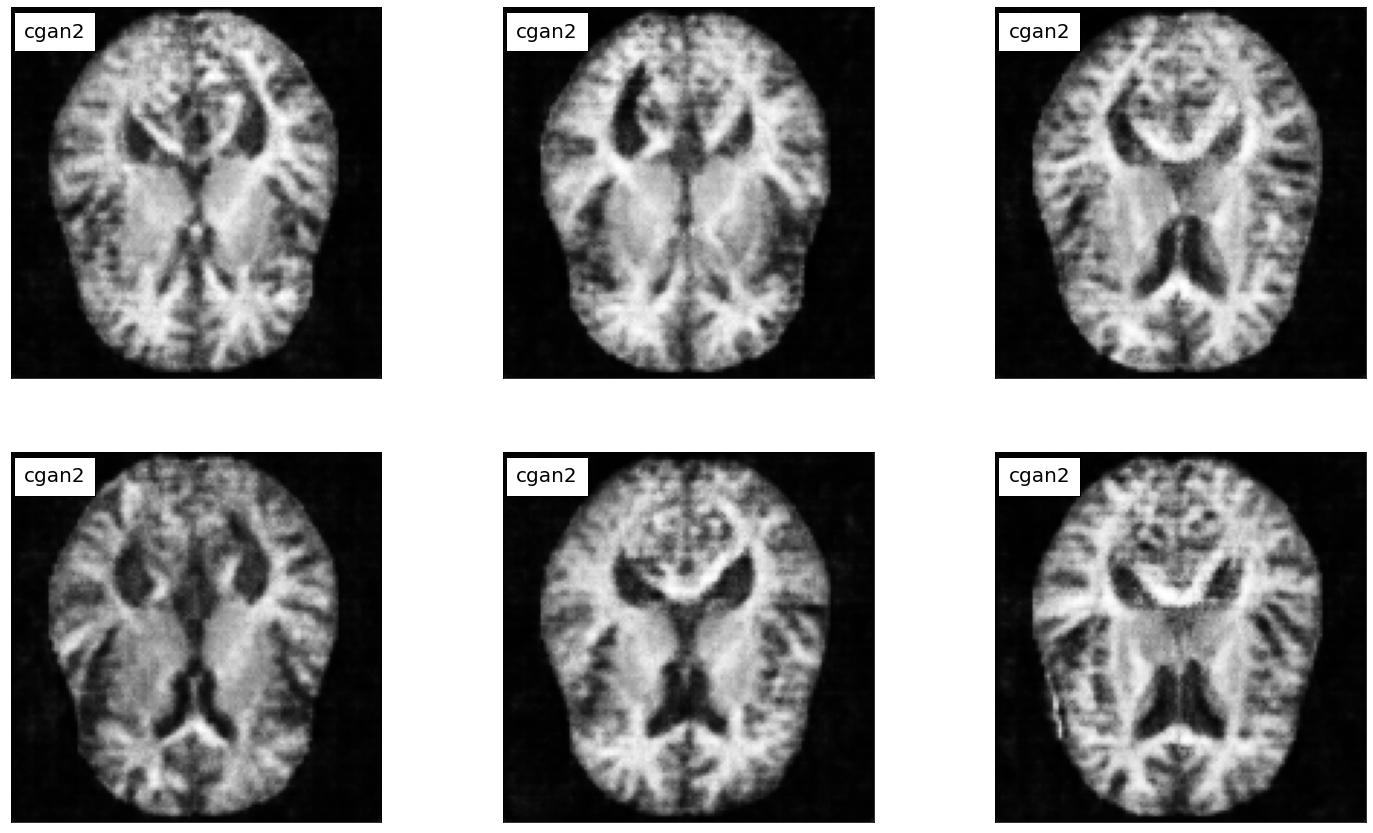

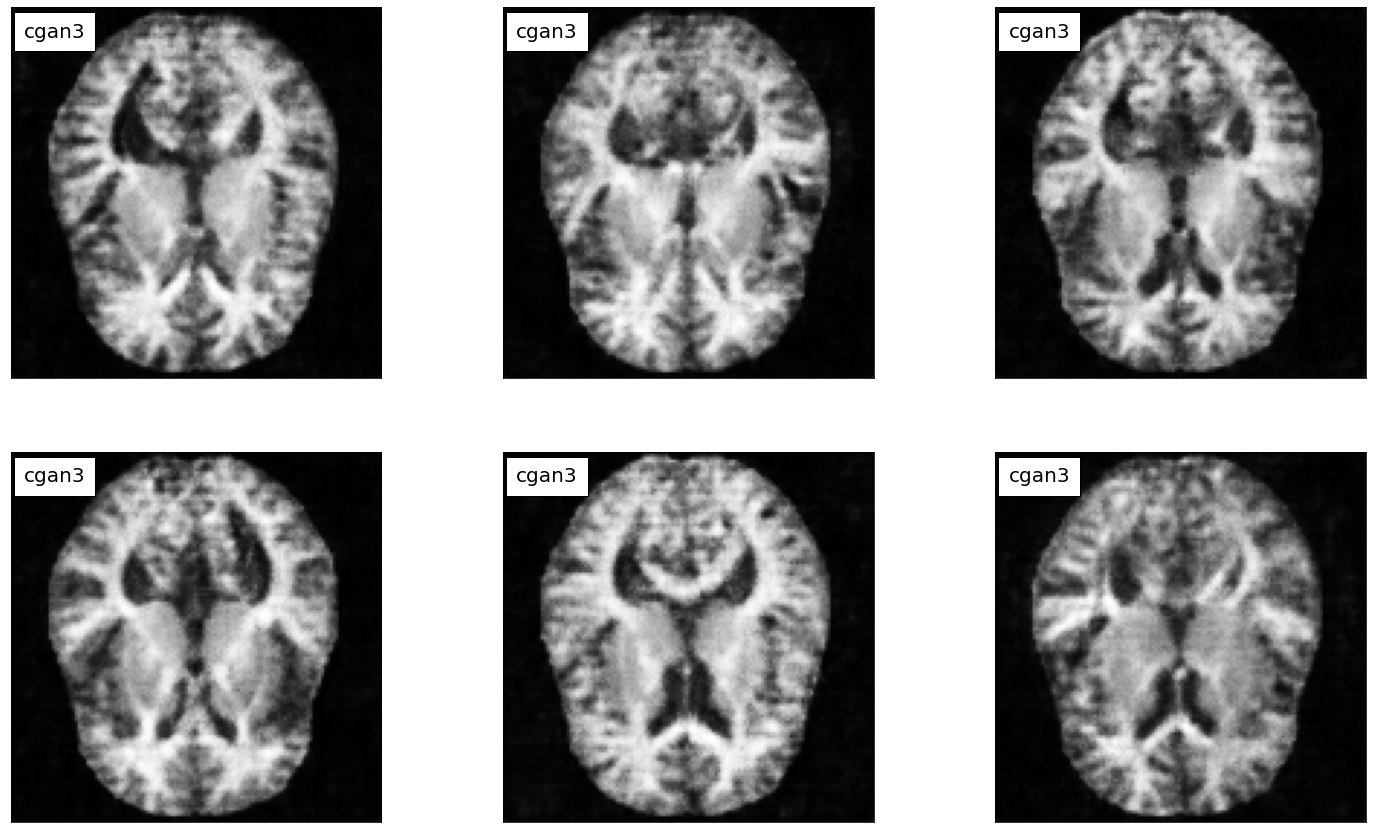

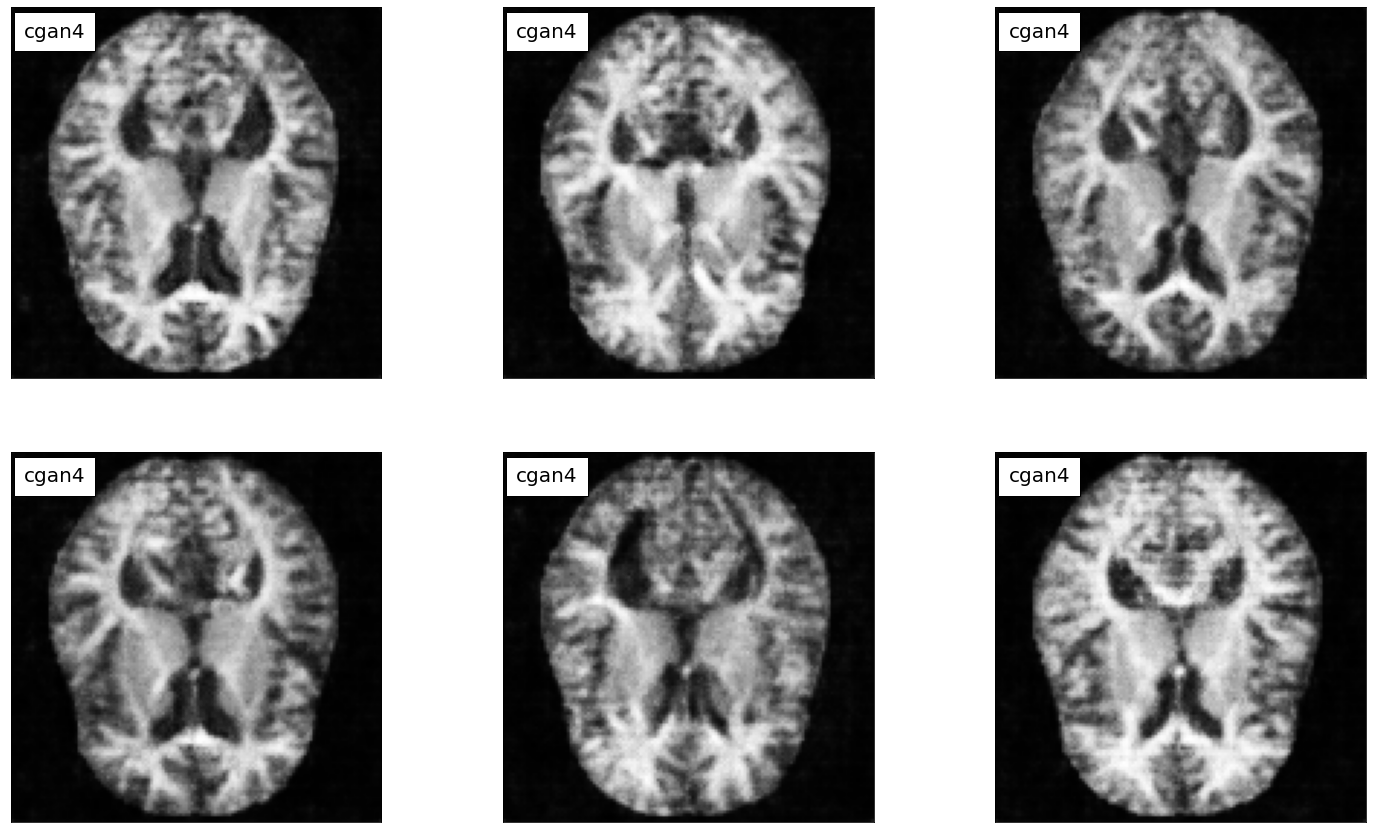

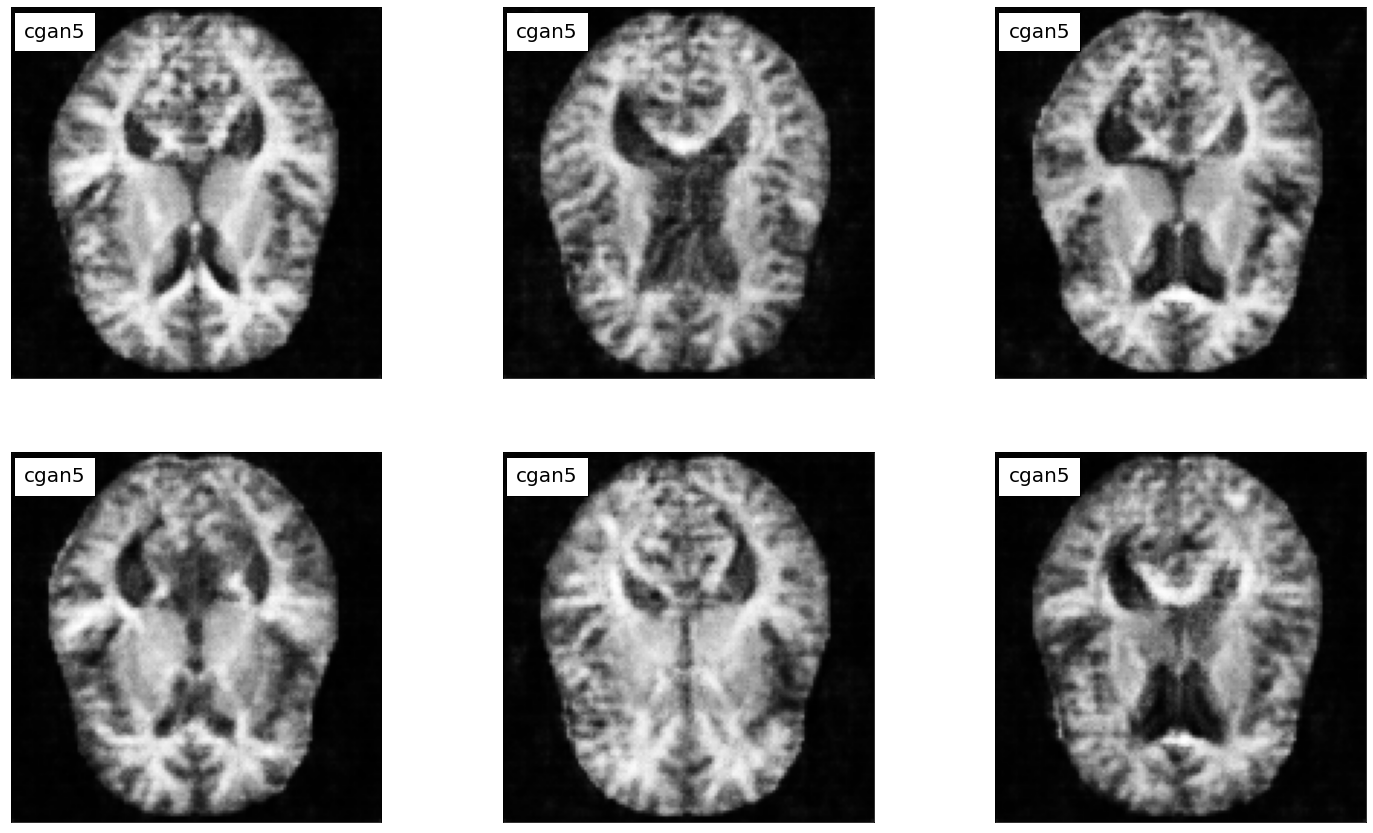

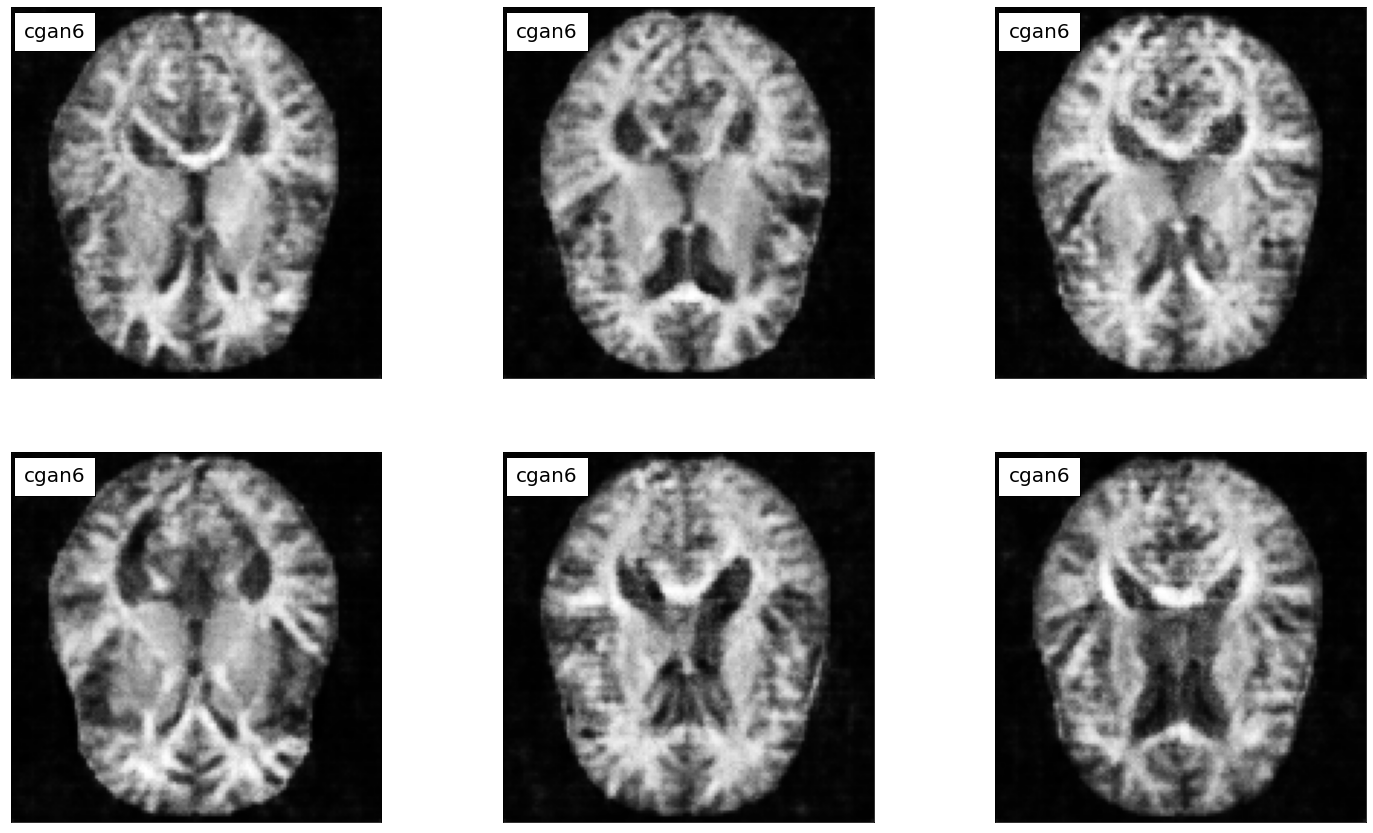

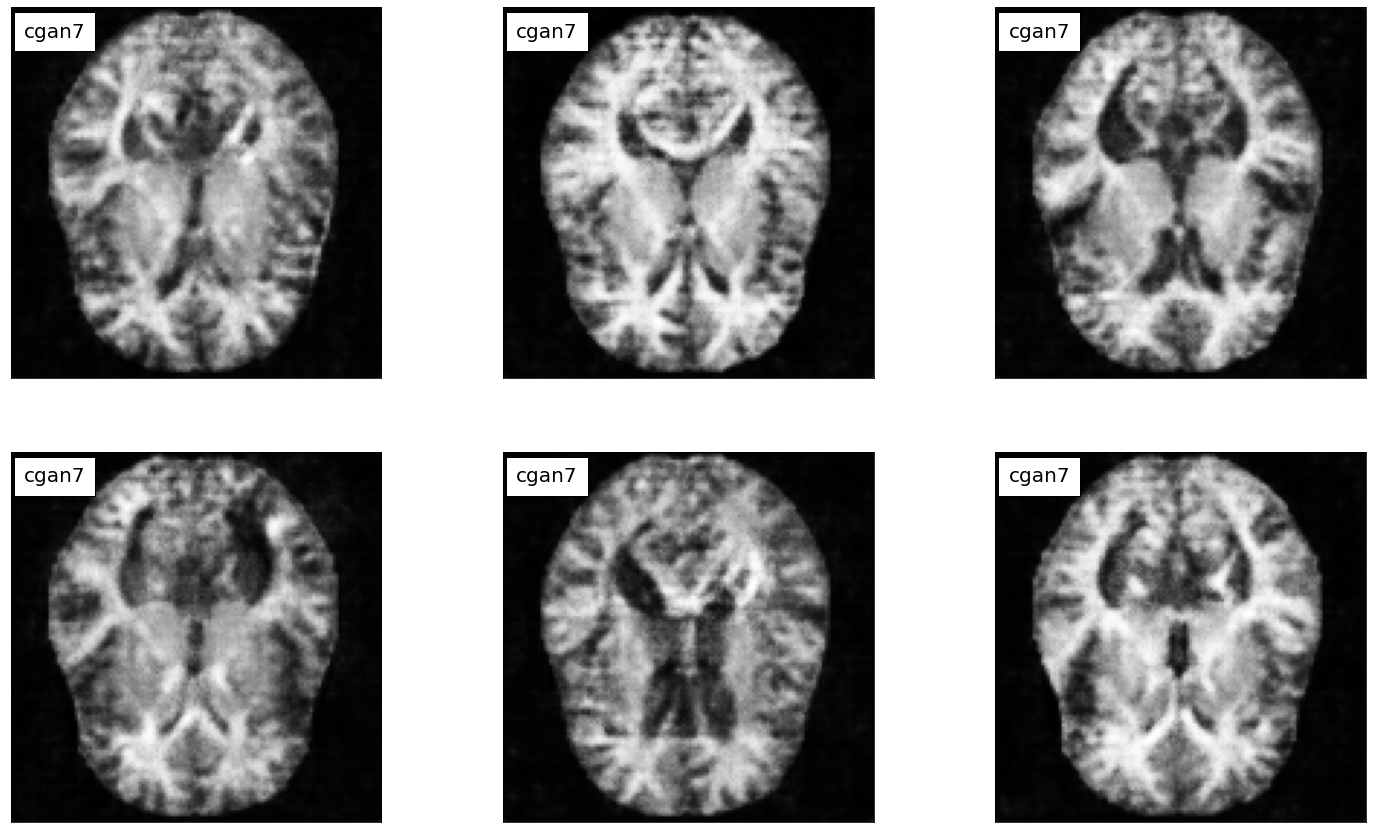

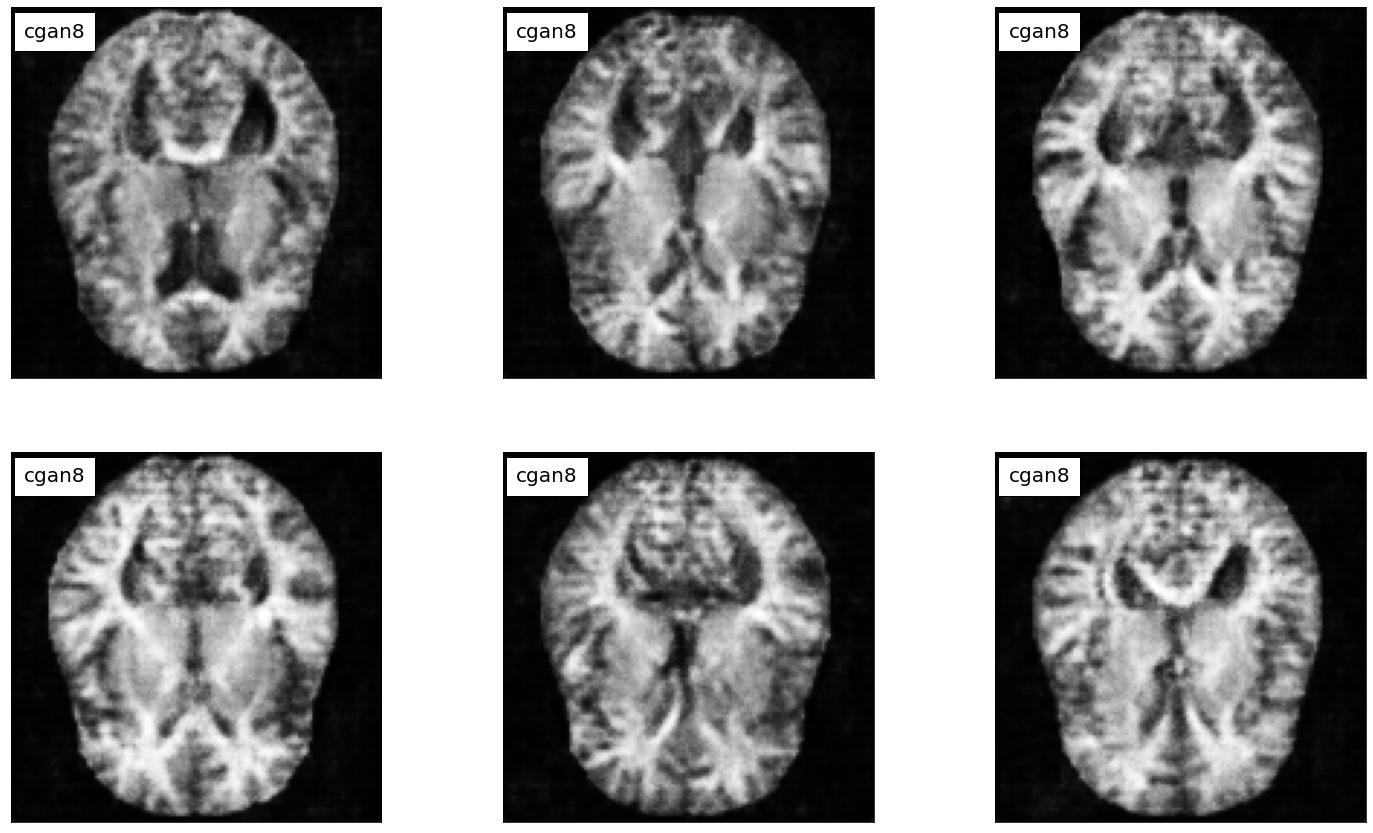

In [9]:
for model_num in range(1, number_of_models_to_train+1):
    model_path = f'{models_folder}/cgan{model_num}'
    print(f' *** instantiating model: {model_path}')

    _, generator = gan_models.build_network(d_conv_dim, g_conv_dim, z_size)
    generator.load_state_dict(torch.load(model_path))
    generator.eval()
    
    sample_size = 6
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if is_train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)

    view_samples(samples_z, legend_lbl=f"cgan{model_num}")

We can see that for any trained and saved model, we can successfully generate brain MRIs using cGANs models.

__Footnote about cGANs implementation:__

Apart from what I ended up implementing above, I also tried a different approach: keep filtering the MRIs dataset in each cycle, so if in the second cycle the model was trained with 2560 images, in the next cycle only 2048 images were used, and in the next one 1639, and so and so forth. But because in each cycle, less and less images were used to train in this cascade, the quality of generated images was not very good even at naked eye. That can also be observed on how unstabled discriminator and generator losses were becoming in each cycle. I wanted to share results of some of those cGANs here:

![](assets/cgan2.diff.png)
![](assets/cgan5.diff.png)

![](assets/cgan3.diff.png)
![](assets/cgan6.diff.png)

![](assets/cgan4.diff.png)
![](assets/cgan7.diff.png)